<a href="https://colab.research.google.com/github/ahmedbellaaj10/GPGPU_TP/blob/main/linear_classification_2021_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Download repository with helper_cuda.h:

In [ ]:
!git clone https://github.com/NVIDIA/cuda-samples.git

fatal: destination path 'cuda-samples' already exists and is not an empty directory.


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code

## CUDA Utilities

In [ ]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Overwriting cuda_stuff.cuh


In [ ]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Overwriting cuda_stuff.cu


## fmatrix Matrix Tools

In [ ]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

////////////////////////////////////////
// basic data structure and access macro
////////////////////////////////////////
typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/** Access element (i,j) of matrix M
 *
 *  Usage example:
 *  For computing A = B^T + C), loop over i and j with:
 *    getfm(A,i,j) = getfm(B,j,i) + getfm(C,i,j);
 **/
#define getfm(M,i,j) (M.data[IDX2C(i,j,M.rows)])

////////////////////////////////////////
// utility functions
////////////////////////////////////////
/** Returns the number of elements in the matrix.
 *
 *  Useful for computing, e.g., the size
 *  of a 1D-vector that contains the same numbers.
 */
 __host__
 __device__
int fmatrix_elements(fmatrix mat);

/** Returns the memory occupied by the matrix elements in bytes
 *  (not including the variables in the struct mat).
 *
 *  Useful for allocating memory for the data.
 */
 __host__
 __device__
int fmatrix_size(fmatrix mat);

/** Assert that the matrix is coherent: all fields nonzero. */
 __host__
 __device__
void fmatrix_assert(fmatrix mat);

////////////////////////////////////////
// Create, copy, destroy
////////////////////////////////////////
/** Allocate memory on host */
fmatrix fmatrix_create_on_host(int rows, int cols);

/** Allocate memory on device */
fmatrix fmatrix_create_on_device(int rows, int cols);

/** Create a matrix representing columns [a,b) of M.
 *  Note that the new matrix uses a pointer to the
 *  data of M. The data is not copied to a new location.
 *  If M is destroyed, this matrix is useless.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Copy data from matrix on device to host
 *  (no memory allocation). */
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);

/** Copy data from matrix on host to device
 *  (no memory allocation). */
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);

/** Copy matrix from device to host, allocating new memory. */
fmatrix fmatrix_copy_to_host(fmatrix mat_device);

/** Copy matrix from host to device, allocating new memory. */
fmatrix fmatrix_copy_to_device(fmatrix mat_host);

/** Free data memory on host.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_host(fmatrix* mat);

/** Free data memory on device.
 *  This zeros out the data pointer of the fmatrix struct,
 *  so a pointer is required. */
void fmatrix_free_on_device(fmatrix* mat);

////////////////////////////////////////
// Input and Output
////////////////////////////////////////

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

/** Print a matrix to a csv file.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_to_csv(const char* filename, fmatrix mat);

/** Read a matrix from a csv file.
 *
 *  This version creates the matrix on the host first.
 */
fmatrix fmatrix_device_from_csv(const char* filename);

////////////////////////////////////////
// Useful
////////////////////////////////////////

/** Create a matrix with random values between -1 and 1
 *  on the device */
fmatrix fmatrix_create_random_on_device(int rows, int cols);

#endif


Overwriting fmatrix.cuh


In [ ]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <curand.h>
#include <curand_kernel.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

// for reading CSV files, we use some C++
#include <iostream>
#include <iomanip>
#include <fstream>
#include <string>

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
//    fmatrix_assert(mat);
     return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

/** We could do it like this, but it would not set our pointer M.data to 0.
... fmatrix_free_on_host(M)
void fmatrix_free_on_host(fmatrix mat) {
    fmatrix_assert(mat);
  free(mat.data);
  mat.data = 0;
  mat.cols = 0;
  mat.rows = 0;
}
*/

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);
    fmatrix A = {
        .data = &getfm(M,0,a),
        .cols = b-a,
        .rows = M.rows
    };
    fmatrix_assert(A);
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}

void fmatrix_device_to_csv(const char* filename, fmatrix mat) {
  // Open file
  FILE* fp = fopen(filename, "w");
  // allocate copy
  fmatrix tmp = fmatrix_copy_to_host(mat);
  for (int i = 0 ; i < tmp.rows; i++){
    for (int j = 0 ; j<tmp.cols; j++){
      // Note: %.15g gives 15 significant digits (full double precision)
      fprintf(fp,"%.15g", getfm(tmp,i,j));
      if (j+1<tmp.cols) {
        fprintf(fp,",");
      }
    }
    fprintf(fp,"\n");
  }
  fmatrix_free_on_host(&tmp);
  // Close file
  fclose(fp);
}

__global__
void fmatrix_create_random_on_device_kernel(fmatrix M) {
    // choose a seed (here: the same each launch)
    unsigned long seed = 0;
    int sequence = 0;
    // first, initialize the random numbers
    curandState state;
    curand_init(seed, sequence, 0, &state);
    for (int i = 0; i < fmatrix_elements(M); ++i) {
        // curand_uniform creates numbers between 0 and 1
        M.data[i] = (curand_uniform(&state)-0.5)*2.0;
    }
}

fmatrix fmatrix_create_random_on_device(int rows, int cols) {
    // Create an uninitialized matrix on the device
    fmatrix M = fmatrix_create_on_device(rows,cols);
    // Call a kernel with a single thread to fill the values
    fmatrix_create_random_on_device_kernel<<<1,1>>>(M);

    return M;
}

/* Count the number of rows and columns in a csv files (without headers) */
void count_elements_in_csv(const char* filename, int* rows, int* cols) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;

  *rows = 0;
  *cols = 0;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int tempcols = 0;
        while (getline(line_stream, value, ',')) {
          ++tempcols;
        }
        if (tempcols > *cols) {
           *cols = tempcols;
        }
        ++(*rows);
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

/** Read the data from a csv file into an fmatrix on the host.
 *  Careful: We assume that the matrix has the right dimensions!
 *  Use count_elements_in_csv(...) to get the dimensions if
 *  unknown.
 */
void fmatrix_fill_from_csv(fmatrix h_M,const char* filename) {
  // Note: for the sake of convenience, we use some C++ functions here
  using namespace std;
  string row_as_string;
  string value;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row = 0;
	if (infile.is_open())
  {
    while (getline(infile, row_as_string, '\n')) {
				istringstream line_stream(row_as_string);
        int col = 0;
        while (getline(line_stream, value, ',')) {
					getfm(h_M,row,col) = strtod(value.c_str(), NULL);
          ++col;
				}
        ++row;
			}
		infile.close();
	}
	else cout << "Cannot open file." << endl;
}

fmatrix fmatrix_device_from_csv(const char* filename) {
  // first read the file to count the number of elements
  int rows = 0;
  int cols = 0;
  count_elements_in_csv(filename,&rows,&cols);

  // allocate the matrix on the host
  fmatrix h_M = fmatrix_create_on_host(rows,cols);

  // read the data into the host matrix
  fmatrix_fill_from_csv(h_M,filename);

  // copy the matrix to the device
  fmatrix M = fmatrix_copy_to_device(h_M);

  // destroy the host matrix
  fmatrix_free_on_host(&h_M);

  return M;
}




Overwriting fmatrix.cu


## Data I/O

In [ ]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Overwriting read_csv.cuh


In [ ]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL);
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Overwriting read_csv.cu


In [ ]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Overwriting preprocess_data.cuh


In [ ]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   ld = number of rows
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;
      }
		}

    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Overwriting preprocess_data.cu


# Code That You Write

## Classifier Math

In [ ]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);

#endif

Overwriting classifier_math.cuh


In [ ]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}


void softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the softmax here ...
    ///////////////////////////////////

    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}



__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.rows);
    assert(A.cols == C.cols);
    assert(B.cols == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

//// Multiplication de matrice avec transposé


__global__
void fmatrix_tmultiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.rows; ++k) {
          getfm(A,i,j) += f*getfm(B,k,i)*getfm(C,k,j);
        }
    }
}

/* Compute A = f*B^T*C */
void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    // fmatrix_assert(A);
    // fmatrix_assert(B);
    // fmatrix_assert(C);
    assert(A.rows == B.cols);
    assert(A.cols == C.cols);
    assert(B.rows == C.rows);

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block
    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}


Overwriting classifier_math.cu


## Evaluating Accuracy


In [ ]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
float evaluate_logloss(fmatrix d_P,fmatrix d_Y);

Overwriting evaluate_accuracy.cuh


In [ ]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////

  /*********************************
  / TO BE COMPLETED
  / ... compute Z = W^T X here ...
  **********************************/

  //////////////////////////////////////////
  // 2. For each column z of Z,
  // find argmax_k z_k
  //////////////////////////////////////////

  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk(
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}


float evaluate_logloss(fmatrix d_P,fmatrix d_Y) {
    assert(d_Y.cols == d_P.cols);
    assert(d_Y.rows == d_P.rows);

  float J = 0.0;

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the logloss here ...
    ///////////////////////////////////

  return J;
}


Overwriting evaluate_accuracy.cu


## Linear Classifier

In [ ]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 4; //12000; // points for training (Google: 12000)
    size_t N_test = 2; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 10;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 1e-7; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////

////      /* Compute A = f*B^T*C */
//// void fmatrix_tmult(fmatrix A, float f, fmatrix B, fmatrix C);
      fmatrix_tmult(d_Z,1.0,d_W,d_X);

      fmatrix_device_print(d_W);
      fmatrix_device_print(d_X);
      fmatrix_device_print(d_Z);

      ///////////////////////////////////
      // TO BE COMPLETED
      ///////////////////////////////////

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

      // evaluate logloss (for reporting only)

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

      // Q:=P-Y
      // compute gradient G = XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G

    ///////////////////////////////////
    // TO BE COMPLETED
    ///////////////////////////////////

      //printf("W:\n");fmatrix_device_print(d_W);

      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Overwriting linear_classification.cu


# Compiling

In [ ]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(76): warning #177-D: variable "learning_rate" was declared but never referenced

linear_classification.cu(130): warning #177-D: variable "batch_pointer" was declared but never referenced



# Experiments

In [ ]:
%%time
!./a.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 6 rows.
Allocated memory for inputs: 6 rows, 9 columns.
Allocated memory for labels: 6 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	
34.19	34.4	33.69	33.64	33.57	33.63	
15	19	17	14	20	29	
5612	7650	720	1501	1454	1387	
1283	1901	174	337	326	236	
1015	1129	333	515	624	671	
472	463	117	226	262	239	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	
Labels (first 10):
0	0	0	0	0	0	
1	1	1	1	1	1	
initial accuracy: 0.000000
[
0.205141,	-0.063689;
0.170715,	0.179966;
0.248233,	-0.182383;
-0.099364,	0.161749;
-0.134007,	0.032545;
-0.013630,	0.077712;
-0.081538,	0.008081;
0.272705,	0.250975;
0.081837,	0.131035
]
[
1.000000,	1.000000,	1.000000,	1.000000;
-114.309998,	-114.470001,	-114.559998,	-114.570000;
34.189999,	34.400002,	33.689999,	33.639999;
15.000000,	19.000000,	17.000000,	14.000000;
5612.000000,	76

Let's plot the logloss and accuracy.

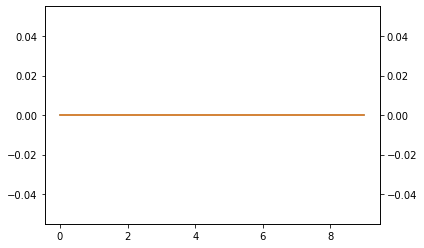

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.show()

# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [ ]:
!nvcc -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

linear_classification.cu(76): warning #177-D: variable "learning_rate" was declared but never referenced

linear_classification.cu(130): warning #177-D: variable "batch_pointer" was declared but never referenced



Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [ ]:
! printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

set cuda memcheck on
set cuda api_failures stop
catch throw
r
bt
info locals
thread 1
bt
Catchpoint 1 (throw)
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
[New Thread 0x7fad67250000 (LWP 6223)]
[Detaching after fork from child process 6224]
[New Thread 0x7fad66723000 (LWP 6233)]
[New Thread 0x7fad65f22000 (LWP 6234)]
original matrix:
[
0.480439;
-0.123098
]
[
0.480439
]
a.out: classifier_math.cu:111: void fmatrix_tmult(fmatrix, float, fmatrix, fmatrix): Assertion `A.rows == B.cols' failed.

Thread 1 "a.out" received signal SIGABRT, Aborted.
0x00007fad69a3800b in raise () from /lib/x86_64-linux-gnu/libc.so.6
#0  0x00007fad69a3800b in raise () from /lib/x86_64-linux-gnu/libc.so.6
#1  0x00007fad69a17859 in abort () from /lib/x86_64-linux-gnu/libc.so.6
#2  0x00007fad69a17729 in ?? () from /lib/x86_64-linux-gnu/libc.so.6
#3  0x00007fad69a28fd6 in __assert_fail () from /lib/x86_64-linux-gnu/libc.so.6
#4  0x00005652aa

In [ ]:
!cuda-memcheck ./a.out

========= CUDA-MEMCHECK
========= This tool is deprecated and will be removed in a future release of the CUDA toolkit
========= Please use the compute-sanitizer tool as a drop-in replacement
headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 6 rows.
Allocated memory for inputs: 6 rows, 9 columns.
Allocated memory for labels: 6 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	
34.19	34.4	33.69	33.64	33.57	33.63	
15	19	17	14	20	29	
5612	7650	720	1501	1454	1387	
1283	1901	174	337	326	236	
1015	1129	333	515	624	671	
472	463	117	226	262	239	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	
Labels (first 10):
0	0	0	0	0	0	
1	1	1	1	1	1	
initial accuracy: 0.000000
iter: 0, logloss: 0.000000, accuracy: 0.000000
iter: 1, logloss: 0.000000, accuracy: 0.000000
iter: 2, logloss: 0.000000, accuracy: 0.000000
iter: 3, logloss: 0.000000, accuracy: 0.000000
iter: 4

# Test


In [ ]:
%%writefile test.cu
#include "fmatrix.cuh"
#include "classifier_math.cu"

int main() {
    // create a random matrix
    fmatrix A = fmatrix_create_random_on_device(2,1);
    fmatrix B = fmatrix_create_random_on_device(1,2);
    fmatrix C = fmatrix_create_random_on_device(1,1);
    printf("original matrix:\n");
    fmatrix_device_print(B);
    fmatrix_device_print(C);
    // add the matrix to itself
    fmatrix_tmult(A,1.0,B,C);
    // print
    printf("matrix result:\n");
    fmatrix_device_print(A);
    // free the memory
    fmatrix_free_on_device(&A);
    fmatrix_free_on_device(&B);
    fmatrix_free_on_device(&C);
}

Overwriting test.cu


In [ ]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -g -G -I cuda-samples/Common/ -L/usr/local/cuda/include test.cu fmatrix.cu cuda_stuff.cu

In [ ]:
!./a.out

original matrix:
[
0.480439,	-0.123098
]
[
0.480439
]
matrix result:
[
0.230821;
-0.059141
]
